In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/MyDrive/python/BayesianFiltering

/content/gdrive/MyDrive/python/BayesianFiltering


In [3]:
from ssm import StateSpaceModel
from ssm import LinearModelParameters
from SLDS import SLDS
from simulation import Simulation
from ssm import LGSSM
import numpy as np
import copy
import matplotlib.pyplot as plt

# Data Generation

## 1 dimensional model

In [ ]:
# a = np.array([0.1])
# h = np.array([1])
# q = np.array([0.01])
# r = np.array([0.01])

# params = LinearModelParameters(a, h, q, r)
# model1 = LGSSM(1,1,params)
# sim1 = Simulation(model1, T = 10, init_state=np.array([0]))

## 2 dimensional model

In [ ]:
# dx = 2
# dy = 2
# A = np.eye(dx)
# H = 1 * np.eye(dy, dx)
# Q = 1 * np.eye(dx)
# R = 0.1 * np.eye(dy)

# init_state = np.zeros([dx])
# params2 = LinearModelParameters(A, H, Q, R)
# model2 = LGSSM(dx, dy, params2)
# sim2 = Simulation(model2, T = 100, init_state=init_state)

## SLDS

In [ ]:
M = 2
dx = 2
dy = 2
T = 100
var_max = 10
correl_mask_dx = np.ones([dx, dx]) - np.eye(dx)
model_parameter_array = np.empty([M], dtype=LinearModelParameters)
init_state = np.zeros([dx])
# for m in range(M):
#     A = np.random.rand() * np.eye(dx)
#     H = 1 * np.eye(dy, dx)
#     #Q_nonsym = var_max * np.multiply(np.random.random([dx, dx]), np.eye(dx)) + \
#     #          np.multiply(np.random.random([dx, dx]), correl_mask_dx)
#     #Q = 1 * (Q_nonsym + Q_nonsym.T)
#     Q = 0.1 * np.random.rand() * np.eye(dx)
#     R = 1000 * np.random.rand() * np.eye(dy)
#     model_parameter_array[m] = LinearModelParameters(A, H, Q, R)

# Fast forgetting
A0 = 1 * np.eye(dx)
H0 = 1 * np.eye(dy, dx)
Q0 = np.array([[10, 0] , [ 0, 0.1]]) #1 * np.eye(dx)
R0 = 1 * np.eye(dy)

# Slow forgetting 
theta = np.pi*5/360
A1 = A0 # 1 * np.array([[np.cos(theta), -np.sin(theta)] , [ np.sin(theta), np.cos(theta)]])
H1 = 1 * np.eye(dy, dx)
Q1 = np.array([[0.1, 0] , [ 0, 10]]) #1 * np.eye(dx)
R1 = 1 * np.random.rand() * np.eye(dy)

model_parameter_array[0] = LinearModelParameters(A0, H0, Q0, R0)
model_parameter_array[1] = LinearModelParameters(A1, H1, Q1, R1)

SLDS1 = SLDS(dx, dy, model_parameter_array)

# alpha = np.random.choice(range(1, 50), M)
# mat = np.random.dirichlet(alpha, M) # Random tranisiton matrix with Dirichlet(alpha) rows
mat = np.array([[0.8, 0.2] , [ 0.2, 0.8]])

SLDS1.set_transition_matrix(mat)

sim3 = Simulation(SLDS1, T, init_state=[0, init_state])

# Filtering

## LGSSM 2D

In [ ]:
# # TODO: functionality for 1D
# filt_model = copy.deepcopy(model2)
# dx = filt_model.dx
# dy = filt_model.dy
# init = [np.zeros(dx), np.eye(dx)]
# out = filt_model.kalman_filter(sim2.observs, init)
# mean_pred = out[0]

## SLDS

### IMM

In [ ]:
filt_slds_model = copy.deepcopy(SLDS1)
dx_slds = filt_slds_model.dx
init_slds = [np.zeros(dx_slds), np.eye(dx_slds)]
out_exact_cond = filt_slds_model.conditional_kalman_filter(sim3.states[0], sim3.observs, init_slds)
mean_out_IMM, cov_out_IMM, weights_out_IMM = filt_slds_model.IMM(sim3.observs, init_slds)

### GPB

In [ ]:
filt_slds_model2 = copy.deepcopy(SLDS1)
dx_slds = filt_slds_model2.dx
init_slds = [np.zeros(dx_slds), np.eye(dx_slds)]
#out_slds = filt_slds_model.conditional_kalman_filter(sim3.states[0], sim3.observs, init_slds)
mean_out_GPB, cov_out_GPB, weights_out_GPB = filt_slds_model2.GPB(5, sim3.observs, init_slds)
#print(mean_out_GPB)

### Error Calculations

In [ ]:
errGPB_trueStates = np.zeros(T)
errIMM_trueStates = np.zeros(T)
errGPB_ExCond = np.zeros(T)
errIMM_ExCond = np.zeros(T)
for t in range(T):
    errGPB_trueStates[t] = np.linalg.norm(mean_out_GPB[t, :] - sim3.states[1][t, :])
    errGPB_ExCond[t] = np.linalg.norm(mean_out_GPB[t, :] - out_exact_cond[0][t, :])
    errIMM_trueStates[t] = np.linalg.norm(mean_out_IMM[t, :] - sim3.states[1][t, :])
    errIMM_ExCond[t] = np.linalg.norm(mean_out_IMM[t, :] - out_exact_cond[0][t, :])


# Plots

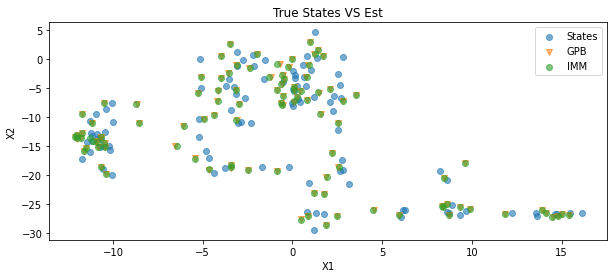

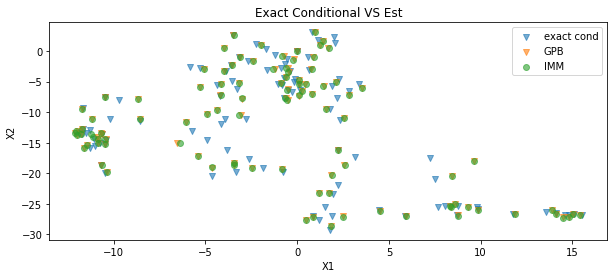

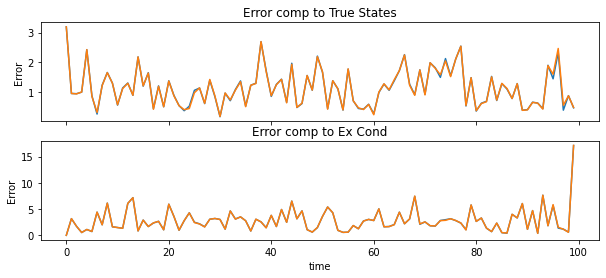

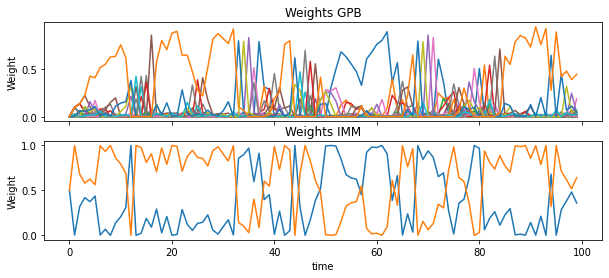

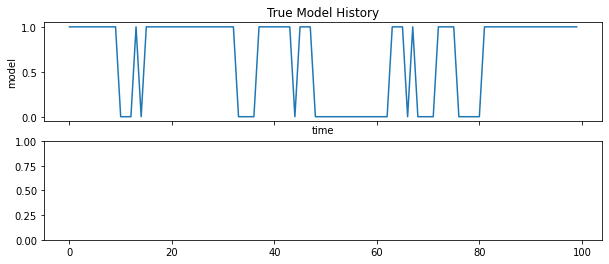

In [ ]:
# Plots
#
fig1, axes1 = plt.subplots(1, 1, sharex=True, figsize=(10, 4))
scatter1 = axes1.scatter(sim3.states[1][:, 0], sim3.states[1][:, 1], alpha=0.6, label="States")
scatter2 = axes1.scatter(mean_out_GPB[:, 0], mean_out_GPB[:, 1], alpha=0.6, marker = "v", label="GPB")
scatter3 = axes1.scatter(mean_out_IMM[:, 0], mean_out_IMM[:, 1], alpha=0.6, label="IMM")
axes1.set_ylabel("X2")
axes1.set_xlabel("X1")
axes1.set_title("True States VS Est")
axes1.legend(handles=[scatter1, scatter2, scatter3])

fig2, axes2 = plt.subplots(1, 1, sharex=True, figsize=(10, 4))
scatter1 = axes2.scatter(out_exact_cond[0][:, 0], out_exact_cond[0][:, 1], alpha=0.6, marker="v", label="exact cond")
scatter2 = axes2.scatter(mean_out_GPB[:, 0], mean_out_GPB[:, 1], alpha=0.6, marker="v", label="GPB")
scatter3 = axes2.scatter(mean_out_IMM[:, 0], mean_out_IMM[:, 1], alpha=0.6, label="IMM")
axes2.set_ylabel("X2")
axes2.set_xlabel("X1")
axes2.set_title("Exact Conditional VS Est")
axes2.legend(handles=[scatter1, scatter2, scatter3])
#
# fig3, axes3 = plt.subplots(1, 1, sharex=True, figsize=(10, 4))
# axes3.plot(sim3.states[0])
# axes3.set_ylabel("t")
# axes3.set_xlabel("Index")
#
fig3, axes3 = plt.subplots(2, 1, sharex=True, figsize=(10, 4))
plot11 = axes3[0].plot(errGPB_trueStates, label="GPB")
plot21 = axes3[0].plot(errIMM_trueStates, label="IMM")
axes3[0].set_ylabel("Error")
#axes3[0].set_xlabel("time")
axes3[0].set_title("Error comp to True States")
#axes3.legend(handles=[plot1, plot2])

plot21 = axes3[1].plot(errGPB_ExCond, label="GPB")
plot22 = axes3[1].plot(errIMM_ExCond, label="IMM")
axes3[1].set_ylabel("Error")
axes3[1].set_xlabel("time")
axes3[1].set_title("Error comp to Ex Cond")
#axes4.legend(handles=[plot1, plot2])

fig4, axes4 = plt.subplots(2, 1, sharex=True, figsize=(10, 4))
plot1 = axes4[0].plot(weights_out_GPB)
axes4[0].set_ylabel("Weight")
#axes4[0].set_xlabel("time")
axes4[0].set_title("Weights GPB")

plot = axes4[1].plot(weights_out_IMM)
axes4[1].set_ylabel("Weight")
axes4[1].set_xlabel("time")
axes4[1].set_title("Weights IMM")

fig5, axes5 = plt.subplots(2, 1, sharex=True, figsize=(10, 4))
axes5[0].plot(sim3.states[0])
axes5[0].set_ylabel("model")
axes5[0].set_xlabel("time")
axes5[0].set_title("True Model History")
plt.show()